# 럭키백의 확률 구하기

## 데이터 준비하기
직접 csv 데이터를 읽어 사용한다. csv 파일을 데이터프레임으로 변환 후 head() 메서드로 출력

In [1]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


> ### 데이터프레임
> 데이터 프레임이란 pandas에서 제공하는 2차원 표 형식 데이터 구조

어떤 종류의 생선이 있는지 Species 열에서 값을 추출. unique() 함수를 사용


In [2]:
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


이 Species 열을 타깃, 나머지를 입력 데이터로 사용.

In [4]:
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


데이터 프레임에서 여러 열을 선택하면 새로운 데이터 프레임으로 반환. 

In [5]:
fish_target = fish['Species'].to_numpy()

이제 데이터를 훈련세트와 테스트세트로 나눈다.

In [7]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

그 다음 사이킷런의 StandardScaler 클래스를 사용해 훈련 세트와 테스트 세트를 표준화 전처리한다. 여기서도 훈련세트의 통계값으로 테스트세트를 변환해야 한다.

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

## 최근접 이웃 분류기의 확률 예측
KNeighborsClassifier 클랙스 객체를 만들고 훈련 세트로 모델 훈련 후 다름 훈련 세트와 테스트 세트의 점수 확인.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


타깃 데이터를 만들 때 fish['Species']를 사용했기 때문에 훈련 세트와 테스트 세트의 타깃 데이터에도 7개의 생선 종류가 들어가 있다. 이렇게 타깃 데이터에 2개 이상의 클래스가 포함된 문제를 다중 분류라고 한다.

이전에서 이진분류에서는 각 클래스를 0, 1로 지정하여 타깃 데이터를 만들었다. 다중 분류에서는 타깃 데이터를 숫자로 표현할 수 있지만 문자열로 된 타깃 값을 그대로 사용할 수 있다.

이때 주의할 점은 타깃값을 그대로 사이킷런 모델에 전달하면 순서가 자동으로 알파벳순으로 매겨진다.

In [10]:
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [11]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


이 5개의 샘플에 대한 예측은 predict_proba() 메서드로 클래스 별 확률값을 반환한다.

In [12]:
import numpy as np
proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals = 4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


predict_proba() 메서드 출력 순서는 classes_ 속성과 같다. 첫번째 열이 Bream의 확률, 두번째 열이 Parkki의 확률.

다음은 4번째 샘플의 최근접 이웃 클래스 확인

In [13]:
distance, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


이 샘플의 이웃은 Roach 1개, Perch가 2개라서 Roach확률 0.3333, Perch확률 0.6667이 된다.

# 로지스틱 회귀
로지스틱 회귀는 분류 모델이다. 이 알고리즘은 선형 회귀와 동일하게 선형 방정식을 학습한다.
예를들면, 
z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f

여기서 a,b,c,d,e는 가중치, 계수 이다. z는 어떠한 값도 될 수 있다. 하지만 확률로 만들기 위해 0~1(0% ~ 100%)로 만들어주어야 한다. z가 아주 큰 음수일 때 0이 되고, 아주 큰 양수일 때 1이 되도록 바꾸어주어야 한다. 시그모이드 함수(로지스틱 함수)를 사용하면 가능하다.

넘파이로 시그모이드 함수를 그릴 수 있다.

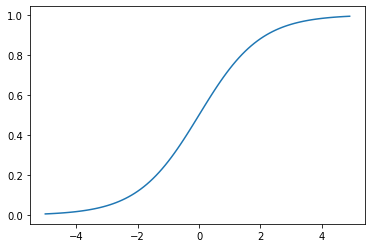

In [14]:
import numpy as np
import matplotlib.pyplot as plt
z = np.arange(-5, 5, 0.1)
phi = 1 / (1 + np.exp(-z))
plt.plot(z, phi)
plt.show()

다음 이진 분류를 시그모이드 함수를 사용하여 수행해보자.
시그모이드 함수 출력이 0.5보다 크면 양성, 작으면 음성 클래스로 판단. 사이킷 런에서 0.5는 음성 클래스로 판단.

## 로지스틱 회귀로 이진 분류 수행
훈련 세트에서 Bream과 Smelt 행만 골라보기
비교 연산자를 사용하여 두개를  True 불리언 인덱싱 가능. 

In [15]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

bream_smelt_indexes 배열은 도미와 빙어일 경우 True, 그 외의 값은 모두 False

이 데이터로 LogisticRegression 훈련. 이 클래스는 선형 모델이므로 sklearn.linear_model 패키지 아래 존재₩

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


두 번째 샘플을 제외 모두 도미로 예측. KNeighborsClassfier와 마찬가지로 예측 확률은 predict_proba() 메서드에서 제공.

In [17]:
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


첫번째 열이 음성클래스, 두번째 열이 양성 클래스 확률이다. Bream과 Smelt중 어떤 것이 음성 클래스고 양성클래스 일까? 사이킷런에서 타깃값은 알파벳 순으로 정렬.

In [18]:
print(lr.classes_)

['Bream' 'Smelt']


선형 회귀에서 로지스틱 회귀가 학습한 계수 확인

In [19]:
print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f
위에서의 값 coef_ 는 a,b,c,d,e의 값이고, intercept_ 는 f를 뜻한다.

z의 값을 구할 수 있는데 decision_functino() 메서드로 z 값을 출력할 수 있다.

In [20]:
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


이 z값을 시그모이드 함수에 통과시키면 확률을 얻을 수 있다. 파이썬의 scipy 라이브러리에도 시그모이드 함수가 있다. expit(), np.exp() 함수를 사용해 분수 계산을 하는 것보다 편리하다.

In [21]:
from scipy.special import expit
print(expit(decisions))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


출력된 값은 predict_proba() 메서드의 두번째 열과 동일하다. 즉 decision_function() 메서드는 양성 클래스에 대한 z값을 반환한다.

## 로지스틱 회귀로 다중 분류 수행
다중 분류에서도 LogisticRegression 클래스를 사용해 분류해보자.

LogisticRegression 클래스는 반복적인 알고리즘 사용. max_iter 매개변수에서 반복 횟수 지정, 기본 100. 여기에 준비한 데이터셋을 사용해 모델을 훈련하면 반복 횟수가 부족하다 발행, 따라서 반복 횟수를 1000개로 늘린다.

또 LogisticRegression은 기본적으로 릿지 회귀와 같이 계수의 제곱을 규제한다. 규제하는 매개변수는 C.
C는 작을수록 규제가 커진다.

In [22]:
lr = LogisticRegression(C = 20, max_iter = 1000)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


훈련 세드와 테스트 세트에 대한 점수가 높고 과대 적합, 과소적합은 아니다. 테스트 세트의 처음 5개 샘플에 대한 예측 출력.

In [23]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


테스트 세트의 처음 5개 샘플에 대한 예측 확률 출력

In [24]:
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


다중 분류일 경우 선형 방정식은 어떻게 될 것인가

In [25]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


coef_는 7행 5열의 배열 형태이고 intercept_도 7개나 가지고 있다.

다중 분류는 클래스마다 z값을 하나씩 계산한다.

이진 분류에서는 시그모이드 함수를 사용해 0과 1 사이의 값으로 변환.

다중 분류에서는 이와 달리 소프트맥스 함수를 사용해 7개의 z값을 확률로 변환. 소프트맥스 함수란 여러개의 선형 방정식의 출력값을 0~1 사이로 압축, 전체 합이 1이 되도록 만든다. 

소프트맥스 함수는 7개의 z값 e^z1, e^z2 ,..,e^z7 을 모두 더한 e_sum값을 구한다. 그 다음 e^z1~e^z7 각각을 e_sum으로 나눈다.

다음은 이진분류에서처럼 decision_function() 메서드로 z1~z7 값을 구한 뒤 소프트맥스 함수를 사용해 확률로 바꾸어보자.

먼저 테스트 세트의 처음 5개 샘플에 대한 z1~z7의 값을 구하자.

In [26]:
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals= 2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


scipy에서는 소프트맥스 함수도 제공, scipy.special 아래에 softmax() 함수 임포트

In [27]:
from scipy.special import softmax
proba = softmax(decision, axis = 1)
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


decision 배열을 softmax() 함수에 전달. axis는 소프트맥스를 계산할 축을 지정. 